In [1]:
# Corrected Installation (no need for separate keras install)
!pip install numpy pillow tensorflow matplotlib kagglehub

In [2]:
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import kagglehub
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Input, Add, Lambda, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Verify TensorFlow version
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [4]:
# Download dataset
path = kagglehub.dataset_download("jagan028/img-superres")
dataset_path = "/root/.cache/kagglehub/datasets/jagan028/img-superres/versions/1/AnalyticsArena_DataSet"

100%|██████████| 448M/448M [00:02<00:00, 160MB/s]

Extracting files...


In [5]:
# Based on your output, here are the correct paths:
lr_train_dir = os.path.join(dataset_path, "lowres", "LowReolution_3x_Train")
hr_train_dir = os.path.join(dataset_path, "highres", "HighResolution_Train")
lr_valid_dir = os.path.join(dataset_path, "lowresvalid", "LowResolution_3x_Valid")
hr_valid_dir = os.path.join(dataset_path, "highresvalid", "HighResolution_Valid")

In [6]:
# Check if directories exist
print(f"Checking directories:")
print(f"LR train: {os.path.exists(lr_train_dir)}")
print(f"HR train: {os.path.exists(hr_train_dir)}")
print(f"LR valid: {os.path.exists(lr_valid_dir)}")
print(f"HR valid: {os.path.exists(hr_valid_dir)}")


Checking directories:
LR train: True
HR train: True
LR valid: True
HR valid: True


In [7]:
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.losses import MeanSquaredError


In [8]:

# Define the perceptual loss model based on VGG19
def build_vgg_perceptual_model():
    """
    Creates a VGG19-based model for perceptual loss calculation.
    Returns a model that will generate feature activations that can be used for perceptual loss.
    """
    # Load pre-trained VGG19 model (without classification layers)
    vgg = VGG19(include_top=False, weights='imagenet', input_shape=(None, None, 3))

    # Freeze the VGG model
    vgg.trainable = False

    # We use specific layers for perceptual loss
    # Content layers - these are good for capturing content details
    content_layers = ['block3_conv3', 'block4_conv3']

    # Create model that outputs specific feature layers
    outputs = [vgg.get_layer(name).output for name in content_layers]

    # Create the perceptual model
    perceptual_model = Model(inputs=vgg.input, outputs=outputs)

    return perceptual_model

In [9]:

# Define the combined loss function (perceptual + MSE)
class PerceptualLoss:
    def __init__(self, perceptual_weight=1.0, mse_weight=1.0):
        """
        Initialize the perceptual loss with weighting factors.
        Args:
            perceptual_weight: Weight for perceptual loss component
            mse_weight: Weight for MSE loss component
        """
        self.perceptual_model = build_vgg_perceptual_model()
        self.mse_loss = MeanSquaredError()
        self.perceptual_weight = perceptual_weight
        self.mse_weight = mse_weight

    def __call__(self, y_true, y_pred):
        """
        Calculate the combined loss.
        Args:
            y_true: Ground truth HR images
            y_pred: Predicted HR images
        Returns:
            Combined loss value
        """
        # 1. Calculate MSE (pixel) loss
        mse_loss_value = self.mse_loss(y_true, y_pred)

        # 2. Calculate perceptual loss
        # Preprocess inputs for VGG19
        y_true_vgg = tf.keras.applications.vgg19.preprocess_input(y_true * 255.0)
        y_pred_vgg = tf.keras.applications.vgg19.preprocess_input(y_pred * 255.0)

        # Get feature activations
        true_features = self.perceptual_model(y_true_vgg)
        pred_features = self.perceptual_model(y_pred_vgg)

        # Calculate MSE between feature representations
        perceptual_loss_value = 0
        for true_feat, pred_feat in zip(true_features, pred_features):
            perceptual_loss_value += self.mse_loss(true_feat, pred_feat)

        # 3. Return combined loss
        return self.mse_weight * mse_loss_value + self.perceptual_weight * perceptual_loss_value

In [10]:
# Modified PSNR function
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def ResBlock(input_layer, filters):
    x = Conv2D(filters, 3, padding='same', activation='relu')(input_layer)
    x = Conv2D(filters, 3, padding='same')(x)
    return Add()([input_layer, x])

In [11]:
def InterConnected(input_shape):
    inputs = Input(input_shape)

    # Initial convolution
    x = Conv2D(64, 3, padding='same', activation='relu')(inputs)  # Increased filters to 64
    skip = x  # Save for skip connection

    # Deeper residual blocks - increased from 2 to 5
    for _ in range(5):
        x = ResBlock(x, 64)

    # Add global skip connection
    x = Add()([x, skip])

    # Upsampling block
    x = Conv2D(64 * (3**2), 3, padding='same')(x)  # 3x upscale factor
    x = Lambda(lambda x: tf.nn.depth_to_space(x, 3))(x)

    # Final convolution
    outputs = Conv2D(3, 1, activation='sigmoid')(x)  # Sigmoid for [0,1] range

    return Model(inputs, outputs)

In [12]:
# Create image data generator function (missing in original code)
def create_simple_generator(lr_dir, hr_dir, batch_size=8):
    """
    Creates a generator that yields batches of LR and HR image pairs.

    Args:
        lr_dir: Directory with low-resolution images
        hr_dir: Directory with high-resolution images
        batch_size: Number of images per batch

    Returns:
        A generator yielding (LR_batch, HR_batch) tuples and number of steps per epoch
    """
    lr_files = sorted([f for f in os.listdir(lr_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    hr_files = sorted([f for f in os.listdir(hr_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

    # Ensure matching file counts
    min_files = min(len(lr_files), len(hr_files))
    lr_files = lr_files[:min_files]
    hr_files = hr_files[:min_files]

    steps_per_epoch = int(np.ceil(min_files / batch_size))

    def generator():
        while True:
            # Shuffle files at the beginning of each epoch
            indices = np.random.permutation(min_files)

            for start_idx in range(0, min_files, batch_size):
                end_idx = min(start_idx + batch_size, min_files)
                batch_indices = indices[start_idx:end_idx]

                lr_batch = []
                hr_batch = []

                for idx in batch_indices:
                    # Load and preprocess LR image
                    lr_img = Image.open(os.path.join(lr_dir, lr_files[idx])).convert('RGB')
                    lr_img = lr_img.resize((170, 170))
                    lr_array = np.array(lr_img) / 255.0

                    # Load and preprocess HR image
                    hr_img = Image.open(os.path.join(hr_dir, hr_files[idx])).convert('RGB')
                    hr_img = hr_img.resize((510, 510))  # 3x upscaling
                    hr_array = np.array(hr_img) / 255.0

                    lr_batch.append(lr_array)
                    hr_batch.append(hr_array)

                yield np.array(lr_batch), np.array(hr_batch)

    # Create the generator
    gen = generator()

    return gen, steps_per_epoch

In [13]:
# Check GPU availability
if len(tf.config.experimental.list_physical_devices('GPU')) > 0:
    print("Using GPU")
else:
    print("Using CPU")

Using GPU


In [14]:


# Check available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set GPU memory growth
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and will be used.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found, using CPU instead.")


GPU is available and will be used.


In [15]:
# Create experiment function to train with both MSE and perceptual loss
def run_experiment(lr_train_dir, hr_train_dir, lr_valid_dir, hr_valid_dir,
                  loss_type="perceptual", epochs=20):
    """
    Run super-resolution training experiment with specified loss type.
    Args:
        lr_train_dir: Directory with low-resolution training images
        hr_train_dir: Directory with high-resolution training images
        lr_valid_dir: Directory with low-resolution validation images
        hr_valid_dir: Directory with high-resolution validation images
        loss_type: Type of loss - "mse" or "perceptual"
        epochs: Number of training epochs
    Returns:
        Trained model and training history
    """
    print(f"Running experiment with {loss_type} loss...")

    # Create data generators
    train_gen, train_steps = create_simple_generator(lr_train_dir, hr_train_dir, batch_size=8)  # Reduced batch size
    val_gen, val_steps = create_simple_generator(lr_valid_dir, hr_valid_dir, batch_size=8)

    # Create model
    model = InterConnected((170, 170, 3))

    # Configure model based on loss type
    if loss_type == "mse":
        model.compile(optimizer=Adam(learning_rate=1e-4),
                    loss='mse',
                    metrics=[psnr])
        model_save_path = "super_res_model_mse.keras"

    elif loss_type == "perceptual":
        # Initialize perceptual loss with weights
        percept_loss = PerceptualLoss(perceptual_weight=0.1, mse_weight=1.0)

        model.compile(optimizer=Adam(learning_rate=1e-4),
                    loss=percept_loss,
                    metrics=[psnr])
        model_save_path = "super_res_model_perceptual.keras"

    # Add early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train model
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        steps_per_epoch=train_steps,
        validation_steps=val_steps,
        callbacks=[early_stop]
    )



    return model, history

In [16]:
# Function to find a valid test image in LR dir and try to match with HR dir
def find_test_image_with_hr(lr_dir, hr_dir):
    if not os.path.exists(lr_dir) or not os.path.exists(hr_dir):
        return None, None

    # Get list of available files
    lr_files = [f for f in os.listdir(lr_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    hr_files = [f for f in os.listdir(hr_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if not lr_files:
        return None, None

    # Try a few approaches to match LR and HR files

    # Approach 1: Try to find exact match
    for lr_file in lr_files:
        if lr_file in hr_files:
            return os.path.join(lr_dir, lr_file), os.path.join(hr_dir, lr_file)

    # Approach 2: Try to find match by number in filename (common in datasets)
    for lr_file in lr_files:
        # Extract numbers from filename
        lr_nums = ''.join(filter(str.isdigit, lr_file))

        if lr_nums:
            for hr_file in hr_files:
                hr_nums = ''.join(filter(str.isdigit, hr_file))
                if lr_nums == hr_nums:
                    return os.path.join(lr_dir, lr_file), os.path.join(hr_dir, hr_file)

    # Approach 3: If no match found, simply use the first file and print a warning
    print("Warning: Could not find matching filenames between LR and HR directories.")
    print("Using first available LR and HR images for visualization.")
    print("The HR image may not correspond to the LR image.")

    return os.path.join(lr_dir, lr_files[0]), os.path.join(hr_dir, hr_files[0])

In [17]:
# Helper function to visualize and compare images
def visualize_results(model_mse, model_perceptual, test_lr_path, test_hr_path):
    """
    Compare results between MSE and perceptual loss models
    """
    # Load test images
    lr_img = Image.open(test_lr_path).resize((170, 170)).convert('RGB')
    hr_img = Image.open(test_hr_path).resize((510, 510)).convert('RGB')

    # Prepare for prediction
    lr_img_arr = np.array(lr_img) / 255.0

    # Predict with both models
    pred_mse = model_mse.predict(np.expand_dims(lr_img_arr, axis=0))[0]
    pred_perceptual = model_perceptual.predict(np.expand_dims(lr_img_arr, axis=0))[0]

    # Convert predictions to displayable format
    pred_mse_disp = (np.clip(pred_mse, 0, 1) * 255).astype(np.uint8)
    pred_perceptual_disp = (np.clip(pred_perceptual, 0, 1) * 255).astype(np.uint8)

    # Display all images
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 4, 1)
    plt.title("Low Resolution (Input)")
    plt.imshow(lr_img)
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title("MSE-based SR")
    plt.imshow(pred_mse_disp)
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title("Perceptual Loss SR")
    plt.imshow(pred_perceptual_disp)
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.title("High Resolution (Ground Truth)")
    plt.imshow(hr_img)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Calculate PSNR for both methods
    hr_img_arr = np.array(hr_img) / 255.0

    psnr_mse = tf.image.psnr(
        tf.convert_to_tensor(hr_img_arr, dtype=tf.float32),
        tf.convert_to_tensor(pred_mse, dtype=tf.float32),
        max_val=1.0
    ).numpy()

    psnr_perceptual = tf.image.psnr(
        tf.convert_to_tensor(hr_img_arr, dtype=tf.float32),
        tf.convert_to_tensor(pred_perceptual, dtype=tf.float32),
        max_val=1.0
    ).numpy()

    # Calculate SSIM for both methods
    ssim_mse = tf.image.ssim(
        tf.convert_to_tensor(hr_img_arr, dtype=tf.float32),
        tf.convert_to_tensor(pred_mse, dtype=tf.float32),
        max_val=1.0
    ).numpy()

    ssim_perceptual = tf.image.ssim(
        tf.convert_to_tensor(hr_img_arr, dtype=tf.float32),
        tf.convert_to_tensor(pred_perceptual, dtype=tf.float32),
        max_val=1.0
    ).numpy()

    print("\nMetrics Comparison:")
    print(f"MSE model - PSNR: {psnr_mse:.2f} dB, SSIM: {ssim_mse:.4f}")
    print(f"Perceptual model - PSNR: {psnr_perceptual:.2f} dB, SSIM: {ssim_perceptual:.4f}")

    return {
        'psnr_mse': psnr_mse,
        'psnr_perceptual': psnr_perceptual,
        'ssim_mse': ssim_mse,
        'ssim_perceptual': ssim_perceptual
    }

In [18]:
# Main execution code - Run both experiments
def main_experiment():
    """
    Run the full experiment comparing MSE and perceptual loss
    """
    # Find a test image pair for later comparison
    test_lr_path, test_hr_path = find_test_image_with_hr(lr_valid_dir, hr_valid_dir)
    if test_lr_path is None or test_hr_path is None:
        test_lr_path, test_hr_path = find_test_image_with_hr(lr_train_dir, hr_train_dir)

    # Run MSE experiment (baseline)
    model_mse, history_mse = run_experiment(
        lr_train_dir, hr_train_dir, lr_valid_dir, hr_valid_dir,
        loss_type="mse", epochs=2  # Reduced epochs for faster experiment
    )

    # Run Perceptual Loss experiment
    model_perceptual, history_perceptual = run_experiment(
        lr_train_dir, hr_train_dir, lr_valid_dir, hr_valid_dir,
        loss_type="perceptual", epochs=2  # Reduced epochs for faster experiment
    )

    # Plot training histories
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history_mse.history['loss'], label='MSE Train Loss')
    plt.plot(history_mse.history['val_loss'], label='MSE Val Loss')
    plt.plot(history_perceptual.history['loss'], label='Perceptual Train Loss')
    plt.plot(history_perceptual.history['val_loss'], label='Perceptual Val Loss')
    plt.legend()
    plt.title('Loss Comparison')

    plt.subplot(1, 2, 2)
    plt.plot(history_mse.history['psnr'], label='MSE Train PSNR')
    plt.plot(history_mse.history['val_psnr'], label='MSE Val PSNR')
    plt.plot(history_perceptual.history['psnr'], label='Perceptual Train PSNR')
    plt.plot(history_perceptual.history['val_psnr'], label='Perceptual Val PSNR')
    plt.legend()
    plt.title('PSNR Metric Comparison')

    plt.tight_layout()
    plt.show()

    # Visualize and compare results
    if test_lr_path and test_hr_path:
        metrics = visualize_results(model_mse, model_perceptual, test_lr_path, test_hr_path)
        return metrics
    else:
        print("No test images found for comparison")
        return None


Running experiment with mse loss...
Epoch 1/2
438/438 ━━━━━━━━━━━━━━━━━━━━ 158s 322ms/step - loss: 0.0192 - psnr: 21.1156 - val_loss: 0.0019 - val_psnr: 27.5638
Epoch 2/2
438/438 ━━━━━━━━━━━━━━━━━━━━ 201s 460ms/step - loss: 0.0018 - psnr: 28.0297 - val_loss: 0.0014 - val_psnr: 29.0739
Running experiment with perceptual loss...
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/2
438/438 ━━━━━━━━━━━━━━━━━━━━ 655s 1s/step - loss: 11093.5391 - psnr: 16.2354 - val_loss: 6040.2319 - val_psnr: 25.4407
Epoch 2/2
438/438 ━━━━━━━━━━━━━━━━━━━━ 573s 1s/step - loss: 5827.2861 - psnr: 25.4745 - val_loss: 5401.2061 - val_psnr: 26.0752


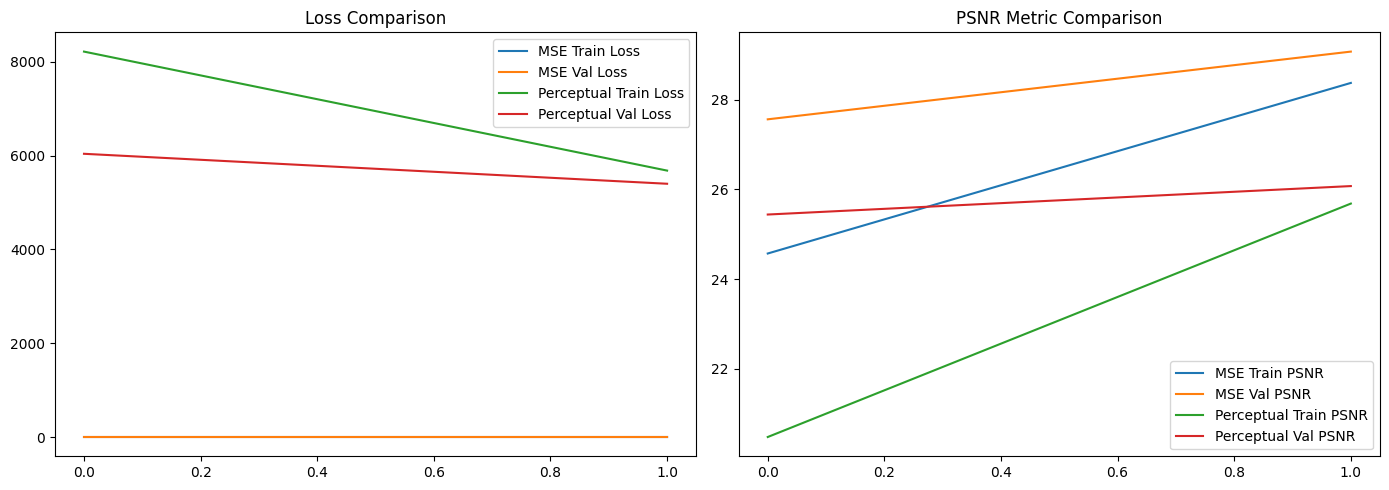

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


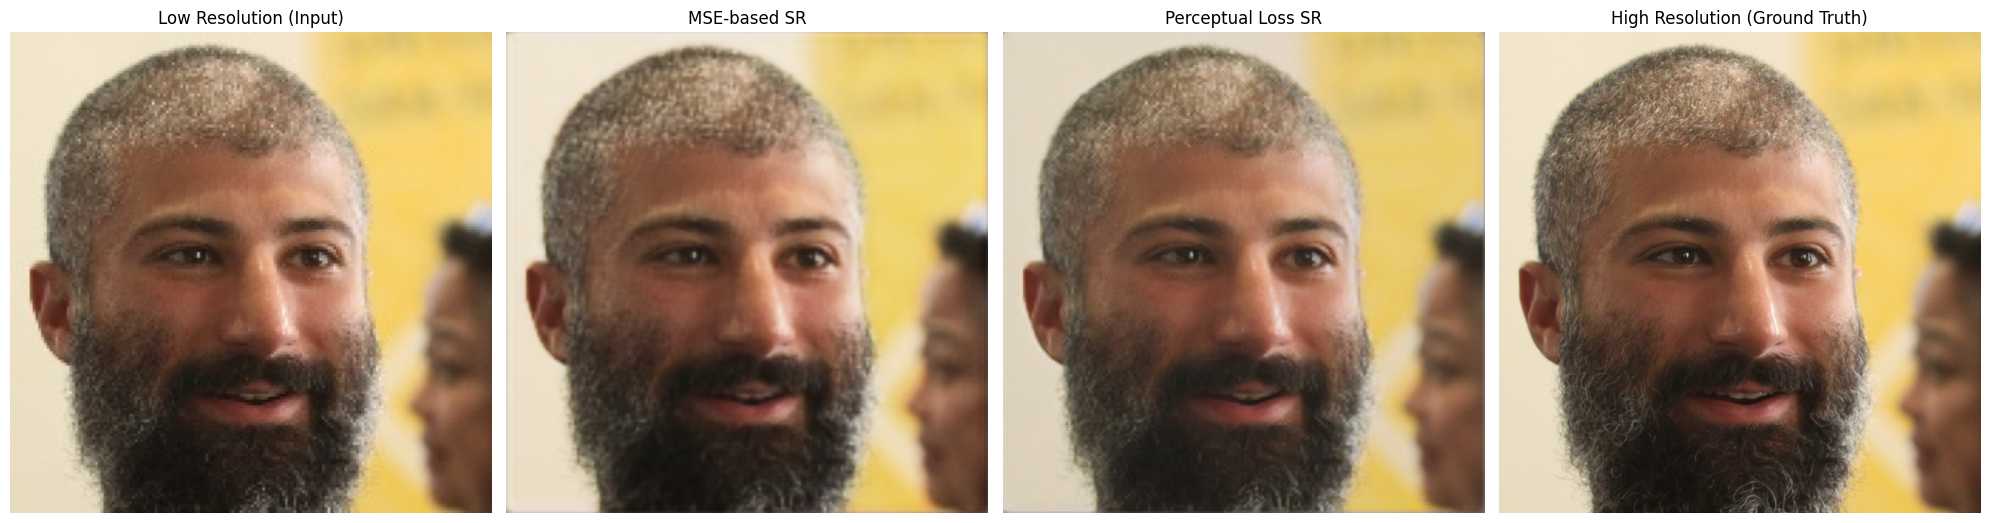


Metrics Comparison:
MSE model - PSNR: 31.17 dB, SSIM: 0.8672
Perceptual model - PSNR: 27.03 dB, SSIM: 0.6274


In [19]:
metrics = main_experiment()